This notebook documents part 3 of the **complementarity of image and demographic information**: combine the image latent spaces and demographics to predict mode choice and trip generation.

In [26]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np
from time import time

import glob
import itertools

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from M1_util_train_test import load_model, test
import mnl

from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo, train_test_split
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
model_type = 'AE'
load_model_name = 'Autoencoder_raw'
load_model_file = 'ae'
model_code = 'BM1_A2'
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '220211'

variable_names = ['active','auto','mas','pt', 'trpgen']


# Load Model Embeddings

In [69]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [70]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Demographics

In [71]:
# demographic variables

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

demo_cs, demo_np = load_demo(data_dir)
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))
demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)
demo_split = train_test_split(demo, data_version='1571')

demo_train = demo_split[~demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)
demo_test = demo_split[demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)


# Load Trip Behavior

In [72]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, str(len(unique_ct)))

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [73]:
embedding_train = aggregate_embeddings[~train_test_index, :]
embedding_test = aggregate_embeddings[train_test_index, :]

In [74]:
x_train = np.concatenate([demo_train, embedding_train], axis=1)
x_test = np.concatenate([demo_test, embedding_test], axis=1)

# MNL for Mode Share

In [12]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [85]:
# decay rates for embedding
w1_list = [0,0.1,0.2,0.3,0.4,0.5,1,1.5,2]
# decay rates for demo
w2_list = [0,0.5,1,1.5,2,2.5,3]
# lr_list = [0.005,0.01, 0.02]
lr_list = [0.001]

for lr in lr_list:
    for w1, w2 in itertools.product(w1_list, w2_list):
        # model setup
        model = mnl.MNL2(n_alts=4, dim_embed=2048*output_dim*output_dim, dim_demo=len(demo_variables),
                        dropout=0)

        embed_params = []
        demo_params = []
        other_params = []
        for name, m in model.named_parameters():
#             print(name)
            if 'embedding' in name:
                embed_params.append(m)
            elif 'demo' in name:
                demo_params.append(m)
            else:
                other_params.append(m)

        optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1},
                                      {'params':demo_params,'weight_decay':w2},
                                      {'params':other_params,'weight_decay':0}], lr=lr)


        # model training
        ref1 = 0
        ref2 = 0

        for epoch in range(500):

            kl_ = 0
            mse_ = 0
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader):
                # Compute prediction and loss
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util, dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()
                mse = mse.sum()

                # Backpropagation
                optimizer.zero_grad()
                kl.backward()
                optimizer.step()


            train_kl = kl_/len(trainset)
            train_mse = np.sqrt(mse_/len(trainset))
            train_mse1 = np.sqrt(mse1_/len(trainset))
            train_mse2 = np.sqrt(mse2_/len(trainset))
            train_mse3 = np.sqrt(mse3_/len(trainset))
            train_mse4 = np.sqrt(mse4_/len(trainset))

            if epoch % 10 == 0:
                print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                    RMSE {train_mse:.3f} \
                    {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
            loss_ = train_kl

            if epoch % 5 == 0:
                if epoch > 50:
                    if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                        print("Early stopping at epoch", epoch)
                        break
                    if (ref1 < loss_) & (ref1 < ref2):
                        print("Diverging. stop.")
                        print("Best epoch:", best_epoch)
                        break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                else:
                    best = loss_
                    best_epoch = epoch

                ref2 = ref1
                ref1 = loss_

            if epoch % 10 == 0:

                kl_ = 0
                mse_ = 0 
                mse1_ = 0
                mse2_ = 0
                mse3_ = 0
                mse4_ = 0

                for batch, (x_batch, y_batch) in enumerate(testloader):
                    util = model(x_batch)
                    probs = torch.log(nn.functional.softmax(util,dim=1))
                    kl = kldivloss(probs, y_batch)
            #         kl = kldivloss(torch.log(util), y_batch)
                    kl_ += kl.item()

                    mse = mseloss(torch.exp(probs), y_batch)
            #         mse = mseloss(util, y_batch)
                    mse_ += mse.sum().item()
                    mse1_ += mse[:,0].sum().item()
                    mse2_ += mse[:,1].sum().item()
                    mse3_ += mse[:,2].sum().item()
                    mse4_ += mse[:,3].sum().item()

                test_kl = kl_/len(testset)
                test_mse = np.sqrt(mse_/len(testset))
                test_mse1 = np.sqrt(mse1_/len(testset))
                test_mse2 = np.sqrt(mse2_/len(testset))
                test_mse3 = np.sqrt(mse3_/len(testset))
                test_mse4 = np.sqrt(mse4_/len(testset))

                r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
                r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
                r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
                r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

                print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                        RMSE {np.sqrt(mse_/len(testset)):.3f} \
                        {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
                print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

        with open(out_dir+model_code+"_mode_choice.csv", "a") as f:
            f.write("%s,%s,%s,%s,%.4f,%.4f,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
                (model_run_date, model_type, zoomlevel, "MNL", lr, w1, w2, 
                  train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                  r1, r2, r3, r4))

[epoch:  0] Train KL loss: 0.610                     RMSE 0.567                     0.166 0.453 0.246 0.167
[epoch:  0] Test KL loss: 0.587                        RMSE 0.555                         0.160 0.446 0.238 0.165
							R2 score: -0.038 -2.925 -37.150 -1.914 
[epoch: 10] Train KL loss: 0.247                     RMSE 0.313                     0.168 0.237 0.064 0.097
[epoch: 10] Test KL loss: 0.229                        RMSE 0.303                         0.160 0.234 0.047 0.097
							R2 score: -0.044 -0.080 -0.465 -0.004 
[epoch: 20] Train KL loss: 0.235                     RMSE 0.307                     0.165 0.233 0.062 0.095
[epoch: 20] Test KL loss: 0.217                        RMSE 0.297                         0.158 0.229 0.040 0.096
							R2 score: -0.017 -0.037 -0.077 0.021 
[epoch: 30] Train KL loss: 0.228                     RMSE 0.302                     0.162 0.228 0.062 0.094
[epoch: 30] Test KL loss: 0.209                        RMSE 0.291                       

[epoch: 150] Train KL loss: 0.139                     RMSE 0.212                     0.118 0.148 0.062 0.072
[epoch: 150] Test KL loss: 0.110                        RMSE 0.183                         0.104 0.129 0.040 0.067
							R2 score: 0.559 0.674 -0.099 0.512 
[epoch: 160] Train KL loss: 0.138                     RMSE 0.211                     0.118 0.147 0.062 0.071
[epoch: 160] Test KL loss: 0.109                        RMSE 0.182                         0.104 0.128 0.040 0.067
							R2 score: 0.561 0.678 -0.099 0.524 
Diverging. stop.
Best epoch: 160
[epoch:  0] Train KL loss: 0.806                     RMSE 0.664                     0.170 0.543 0.208 0.271
[epoch:  0] Test KL loss: 0.772                        RMSE 0.652                         0.164 0.535 0.206 0.263
							R2 score: -0.087 -4.642 -27.715 -6.413 
[epoch: 10] Train KL loss: 0.238                     RMSE 0.308                     0.165 0.232 0.062 0.098
[epoch: 10] Test KL loss: 0.217                        R

[epoch: 130] Train KL loss: 0.140                     RMSE 0.212                     0.119 0.148 0.063 0.070
[epoch: 130] Test KL loss: 0.110                        RMSE 0.184                         0.105 0.130 0.040 0.066
							R2 score: 0.556 0.667 -0.091 0.530 
[epoch: 140] Train KL loss: 0.139                     RMSE 0.211                     0.118 0.148 0.063 0.070
[epoch: 140] Test KL loss: 0.110                        RMSE 0.184                         0.105 0.130 0.040 0.066
							R2 score: 0.555 0.667 -0.076 0.540 
Diverging. stop.
Best epoch: 140
[epoch:  0] Train KL loss: 1.153                     RMSE 0.773                     0.179 0.639 0.277 0.283
[epoch:  0] Test KL loss: 1.097                        RMSE 0.761                         0.173 0.631 0.274 0.277
							R2 score: -0.212 -6.856 -49.407 -7.246 
[epoch: 10] Train KL loss: 0.274                     RMSE 0.323                     0.172 0.244 0.065 0.106
[epoch: 10] Test KL loss: 0.239                        R

[epoch: 90] Train KL loss: 0.146                     RMSE 0.218                     0.122 0.152 0.064 0.072
[epoch: 90] Test KL loss: 0.117                        RMSE 0.191                         0.108 0.135 0.043 0.068
							R2 score: 0.525 0.642 -0.272 0.502 
[epoch: 100] Train KL loss: 0.143                     RMSE 0.215                     0.120 0.150 0.063 0.072
[epoch: 100] Test KL loss: 0.113                        RMSE 0.186                         0.106 0.130 0.043 0.067
							R2 score: 0.544 0.665 -0.223 0.524 
[epoch: 110] Train KL loss: 0.141                     RMSE 0.213                     0.119 0.149 0.063 0.071
[epoch: 110] Test KL loss: 0.112                        RMSE 0.185                         0.105 0.130 0.042 0.066
							R2 score: 0.551 0.665 -0.212 0.537 
[epoch: 120] Train KL loss: 0.140                     RMSE 0.212                     0.119 0.148 0.063 0.071
[epoch: 120] Test KL loss: 0.109                        RMSE 0.181                         0

[epoch: 60] Train KL loss: 0.162                     RMSE 0.237                     0.132 0.170 0.063 0.078
[epoch: 60] Test KL loss: 0.144                        RMSE 0.221                         0.122 0.161 0.044 0.076
							R2 score: 0.392 0.487 -0.285 0.381 
[epoch: 70] Train KL loss: 0.154                     RMSE 0.228                     0.127 0.162 0.063 0.076
[epoch: 70] Test KL loss: 0.128                        RMSE 0.205                         0.116 0.146 0.042 0.073
							R2 score: 0.455 0.577 -0.189 0.432 
[epoch: 80] Train KL loss: 0.150                     RMSE 0.225                     0.125 0.159 0.063 0.075
[epoch: 80] Test KL loss: 0.142                        RMSE 0.218                         0.118 0.162 0.044 0.075
							R2 score: 0.436 0.483 -0.277 0.400 
Diverging. stop.
Best epoch: 80
[epoch:  0] Train KL loss: 1.139                     RMSE 0.777                     0.186 0.644 0.188 0.345
[epoch:  0] Test KL loss: 1.092                        RMSE 0.768

[epoch: 90] Train KL loss: 0.151                     RMSE 0.222                     0.124 0.156 0.064 0.074
[epoch: 90] Test KL loss: 0.123                        RMSE 0.201                         0.115 0.142 0.043 0.073
							R2 score: 0.463 0.604 -0.223 0.423 
[epoch: 100] Train KL loss: 0.149                     RMSE 0.220                     0.123 0.155 0.064 0.074
[epoch: 100] Test KL loss: 0.119                        RMSE 0.195                         0.111 0.137 0.043 0.071
							R2 score: 0.495 0.632 -0.236 0.462 
[epoch: 110] Train KL loss: 0.146                     RMSE 0.218                     0.122 0.152 0.063 0.073
[epoch: 110] Test KL loss: 0.120                        RMSE 0.192                         0.109 0.136 0.043 0.069
							R2 score: 0.517 0.635 -0.263 0.493 
Diverging. stop.
Best epoch: 110
[epoch:  0] Train KL loss: 0.886                     RMSE 0.693                     0.184 0.575 0.223 0.258
[epoch:  0] Test KL loss: 0.848                        RMSE 

[epoch: 10] Train KL loss: 0.246                     RMSE 0.314                     0.167 0.238 0.062 0.100
[epoch: 10] Test KL loss: 0.232                        RMSE 0.306                         0.163 0.236 0.044 0.099
							R2 score: -0.078 -0.100 -0.304 -0.042 
[epoch: 20] Train KL loss: 0.239                     RMSE 0.308                     0.165 0.233 0.062 0.098
[epoch: 20] Test KL loss: 0.220                        RMSE 0.297                         0.160 0.228 0.041 0.096
							R2 score: -0.037 -0.021 -0.133 0.002 
[epoch: 30] Train KL loss: 0.230                     RMSE 0.301                     0.162 0.226 0.062 0.096
[epoch: 30] Test KL loss: 0.210                        RMSE 0.289                         0.157 0.220 0.040 0.094
							R2 score: 0.002 0.044 -0.091 0.047 
[epoch: 40] Train KL loss: 0.220                     RMSE 0.294                     0.159 0.220 0.062 0.094
[epoch: 40] Test KL loss: 0.200                        RMSE 0.280                         0.

[epoch: 90] Train KL loss: 0.161                     RMSE 0.233                     0.128 0.166 0.064 0.079
[epoch: 90] Test KL loss: 0.135                        RMSE 0.211                         0.115 0.152 0.043 0.077
							R2 score: 0.458 0.544 -0.263 0.356 
[epoch: 100] Train KL loss: 0.160                     RMSE 0.233                     0.128 0.166 0.064 0.079
Diverging. stop.
Best epoch: 95
[epoch:  0] Train KL loss: 1.020                     RMSE 0.750                     0.282 0.622 0.092 0.296
[epoch:  0] Test KL loss: 0.975                        RMSE 0.740                         0.270 0.617 0.088 0.294
							R2 score: -1.954 -6.506 -4.169 -8.253 
[epoch: 10] Train KL loss: 0.250                     RMSE 0.319                     0.167 0.244 0.063 0.101
[epoch: 10] Test KL loss: 0.234                        RMSE 0.310                         0.162 0.241 0.044 0.100
							R2 score: -0.072 -0.146 -0.300 -0.070 
[epoch: 20] Train KL loss: 0.238                     RMSE 

[epoch: 80] Train KL loss: 0.171                     RMSE 0.243                     0.134 0.174 0.064 0.083
[epoch: 80] Test KL loss: 0.147                        RMSE 0.222                         0.123 0.161 0.045 0.081
							R2 score: 0.390 0.490 -0.340 0.304 
[epoch: 90] Train KL loss: 0.166                     RMSE 0.237                     0.130 0.169 0.064 0.080
[epoch: 90] Test KL loss: 0.138                        RMSE 0.215                         0.120 0.155 0.043 0.079
							R2 score: 0.418 0.528 -0.259 0.328 
[epoch: 100] Train KL loss: 0.160                     RMSE 0.233                     0.129 0.165 0.064 0.080
[epoch: 100] Test KL loss: 0.144                        RMSE 0.215                         0.117 0.157 0.047 0.077
							R2 score: 0.448 0.514 -0.471 0.361 
[epoch: 110] Train KL loss: 0.156                     RMSE 0.228                     0.126 0.161 0.064 0.078
[epoch: 110] Test KL loss: 0.130                        RMSE 0.204                         0.1

[epoch: 140] Train KL loss: 0.178                     RMSE 0.251                     0.135 0.183 0.062 0.086
[epoch: 140] Test KL loss: 0.152                        RMSE 0.235                         0.125 0.175 0.040 0.085
							R2 score: 0.363 0.399 -0.103 0.217 
[epoch: 150] Train KL loss: 0.175                     RMSE 0.250                     0.135 0.182 0.062 0.086
[epoch: 150] Test KL loss: 0.153                        RMSE 0.229                         0.120 0.171 0.044 0.084
							R2 score: 0.411 0.425 -0.287 0.245 
[epoch: 160] Train KL loss: 0.172                     RMSE 0.246                     0.133 0.178 0.062 0.085
[epoch: 160] Test KL loss: 0.147                        RMSE 0.225                         0.119 0.166 0.042 0.083
							R2 score: 0.424 0.455 -0.199 0.257 
[epoch: 170] Train KL loss: 0.170                     RMSE 0.244                     0.132 0.176 0.062 0.084
[epoch: 170] Test KL loss: 0.143                        RMSE 0.223                        

[epoch: 130] Train KL loss: 0.178                     RMSE 0.253                     0.140 0.183 0.063 0.082
[epoch: 130] Test KL loss: 0.155                        RMSE 0.236                         0.131 0.173 0.041 0.083
							R2 score: 0.308 0.410 -0.124 0.265 
[epoch: 140] Train KL loss: 0.175                     RMSE 0.251                     0.139 0.181 0.063 0.081
[epoch: 140] Test KL loss: 0.150                        RMSE 0.231                         0.128 0.169 0.041 0.082
							R2 score: 0.334 0.439 -0.139 0.285 
[epoch: 150] Train KL loss: 0.170                     RMSE 0.245                     0.137 0.177 0.063 0.080
[epoch: 150] Test KL loss: 0.147                        RMSE 0.226                         0.125 0.164 0.042 0.080
							R2 score: 0.364 0.467 -0.185 0.307 
[epoch: 160] Train KL loss: 0.167                     RMSE 0.241                     0.135 0.173 0.063 0.079
[epoch: 160] Test KL loss: 0.144                        RMSE 0.221                        

[epoch: 90] Train KL loss: 0.192                     RMSE 0.268                     0.146 0.197 0.062 0.088
[epoch: 90] Test KL loss: 0.171                        RMSE 0.250                         0.136 0.187 0.043 0.086
							R2 score: 0.253 0.309 -0.240 0.207 
[epoch: 100] Train KL loss: 0.185                     RMSE 0.261                     0.142 0.191 0.062 0.086
[epoch: 100] Test KL loss: 0.163                        RMSE 0.242                         0.132 0.180 0.042 0.084
							R2 score: 0.294 0.360 -0.212 0.236 
[epoch: 110] Train KL loss: 0.179                     RMSE 0.255                     0.140 0.185 0.062 0.085
[epoch: 110] Test KL loss: 0.156                        RMSE 0.235                         0.128 0.174 0.043 0.083
							R2 score: 0.334 0.403 -0.220 0.264 
[epoch: 120] Train KL loss: 0.173                     RMSE 0.248                     0.136 0.179 0.063 0.083
[epoch: 120] Test KL loss: 0.149                        RMSE 0.230                         0

[epoch: 100] Train KL loss: 0.183                     RMSE 0.259                     0.141 0.189 0.063 0.085
[epoch: 100] Test KL loss: 0.158                        RMSE 0.240                         0.132 0.178 0.040 0.085
							R2 score: 0.297 0.375 -0.093 0.233 
[epoch: 110] Train KL loss: 0.178                     RMSE 0.253                     0.138 0.184 0.063 0.084
[epoch: 110] Test KL loss: 0.152                        RMSE 0.238                         0.131 0.175 0.039 0.084
							R2 score: 0.305 0.393 -0.049 0.243 
[epoch: 120] Train KL loss: 0.172                     RMSE 0.245                     0.134 0.177 0.063 0.082
[epoch: 120] Test KL loss: 0.146                        RMSE 0.231                         0.128 0.170 0.040 0.083
							R2 score: 0.338 0.431 -0.058 0.270 
[epoch: 130] Train KL loss: 0.168                     RMSE 0.244                     0.134 0.176 0.063 0.081
[epoch: 130] Test KL loss: 0.143                        RMSE 0.220                        

[epoch: 90] Train KL loss: 0.207                     RMSE 0.282                     0.151 0.211 0.062 0.093
[epoch: 90] Test KL loss: 0.185                        RMSE 0.267                         0.141 0.203 0.040 0.092
							R2 score: 0.196 0.187 -0.085 0.092 
[epoch: 100] Train KL loss: 0.203                     RMSE 0.279                     0.149 0.208 0.062 0.092
[epoch: 100] Test KL loss: 0.181                        RMSE 0.263                         0.139 0.200 0.040 0.091
							R2 score: 0.218 0.212 -0.083 0.109 
[epoch: 110] Train KL loss: 0.199                     RMSE 0.275                     0.147 0.205 0.062 0.091
[epoch: 110] Test KL loss: 0.177                        RMSE 0.259                         0.137 0.197 0.040 0.090
							R2 score: 0.238 0.237 -0.073 0.126 
[epoch: 120] Train KL loss: 0.197                     RMSE 0.272                     0.146 0.202 0.062 0.090
[epoch: 120] Test KL loss: 0.172                        RMSE 0.256                         0

[epoch: 60] Train KL loss: 0.211                     RMSE 0.287                     0.155 0.215 0.062 0.091
[epoch: 60] Test KL loss: 0.190                        RMSE 0.273                         0.147 0.208 0.040 0.090
							R2 score: 0.117 0.147 -0.091 0.128 
[epoch: 70] Train KL loss: 0.207                     RMSE 0.283                     0.153 0.212 0.062 0.090
[epoch: 70] Test KL loss: 0.185                        RMSE 0.269                         0.145 0.205 0.040 0.090
							R2 score: 0.143 0.174 -0.090 0.140 
[epoch: 80] Train KL loss: 0.203                     RMSE 0.281                     0.152 0.209 0.062 0.090
[epoch: 80] Test KL loss: 0.183                        RMSE 0.266                         0.143 0.202 0.041 0.089
							R2 score: 0.173 0.197 -0.148 0.155 
[epoch: 90] Train KL loss: 0.200                     RMSE 0.277                     0.150 0.206 0.062 0.089
[epoch: 90] Test KL loss: 0.178                        RMSE 0.262                         0.141 0

[epoch: 20] Train KL loss: 0.234                     RMSE 0.306                     0.164 0.231 0.062 0.096
[epoch: 20] Test KL loss: 0.215                        RMSE 0.293                         0.158 0.224 0.041 0.095
							R2 score: -0.010 0.007 -0.156 0.036 
[epoch: 30] Train KL loss: 0.228                     RMSE 0.301                     0.162 0.227 0.062 0.094
[epoch: 30] Test KL loss: 0.208                        RMSE 0.288                         0.155 0.220 0.041 0.094
							R2 score: 0.023 0.047 -0.109 0.060 
[epoch: 40] Train KL loss: 0.222                     RMSE 0.297                     0.160 0.223 0.062 0.094
[epoch: 40] Test KL loss: 0.202                        RMSE 0.283                         0.153 0.216 0.040 0.093
							R2 score: 0.053 0.083 -0.087 0.079 
[epoch: 50] Train KL loss: 0.217                     RMSE 0.292                     0.158 0.219 0.062 0.093
[epoch: 50] Test KL loss: 0.197                        RMSE 0.278                         0.150 

[epoch: 30] Train KL loss: 0.231                     RMSE 0.303                     0.160 0.230 0.062 0.099
[epoch: 30] Test KL loss: 0.206                        RMSE 0.286                         0.151 0.219 0.040 0.096
							R2 score: 0.073 0.050 -0.084 0.004 
[epoch: 40] Train KL loss: 0.227                     RMSE 0.300                     0.158 0.227 0.062 0.098
[epoch: 40] Test KL loss: 0.201                        RMSE 0.282                         0.149 0.216 0.040 0.095
							R2 score: 0.093 0.081 -0.072 0.027 
[epoch: 50] Train KL loss: 0.223                     RMSE 0.296                     0.157 0.224 0.062 0.097
[epoch: 50] Test KL loss: 0.197                        RMSE 0.279                         0.148 0.213 0.040 0.094
							R2 score: 0.111 0.104 -0.070 0.043 
[epoch: 60] Train KL loss: 0.219                     RMSE 0.293                     0.155 0.221 0.062 0.096
[epoch: 60] Test KL loss: 0.195                        RMSE 0.276                         0.146 0

[epoch: 120] Train KL loss: 0.200                     RMSE 0.277                     0.151 0.206 0.062 0.088
[epoch: 120] Test KL loss: 0.179                        RMSE 0.262                         0.141 0.198 0.040 0.088
							R2 score: 0.189 0.226 -0.100 0.175 
[epoch: 130] Train KL loss: 0.198                     RMSE 0.275                     0.150 0.204 0.062 0.088
[epoch: 130] Test KL loss: 0.177                        RMSE 0.259                         0.140 0.196 0.041 0.087
							R2 score: 0.204 0.242 -0.111 0.186 
[epoch: 140] Train KL loss: 0.196                     RMSE 0.273                     0.149 0.203 0.062 0.087
[epoch: 140] Test KL loss: 0.173                        RMSE 0.258                         0.139 0.194 0.040 0.087
							R2 score: 0.211 0.256 -0.080 0.190 
[epoch: 150] Train KL loss: 0.195                     RMSE 0.272                     0.148 0.201 0.062 0.087
[epoch: 150] Test KL loss: 0.171                        RMSE 0.255                        

[epoch: 50] Train KL loss: 0.224                     RMSE 0.296                     0.157 0.223 0.062 0.098
[epoch: 50] Test KL loss: 0.202                        RMSE 0.282                         0.150 0.215 0.040 0.095
							R2 score: 0.085 0.086 -0.086 0.029 
[epoch: 60] Train KL loss: 0.220                     RMSE 0.294                     0.156 0.221 0.062 0.097
[epoch: 60] Test KL loss: 0.198                        RMSE 0.279                         0.149 0.213 0.040 0.094
							R2 score: 0.104 0.107 -0.091 0.043 
[epoch: 70] Train KL loss: 0.218                     RMSE 0.292                     0.155 0.219 0.062 0.096
[epoch: 70] Test KL loss: 0.195                        RMSE 0.276                         0.147 0.210 0.040 0.094
							R2 score: 0.122 0.126 -0.091 0.056 
[epoch: 80] Train KL loss: 0.214                     RMSE 0.288                     0.153 0.216 0.062 0.095
[epoch: 80] Test KL loss: 0.192                        RMSE 0.274                         0.145 0

[epoch: 130] Train KL loss: 0.194                     RMSE 0.271                     0.146 0.201 0.062 0.089
[epoch: 130] Test KL loss: 0.173                        RMSE 0.254                         0.135 0.191 0.041 0.088
							R2 score: 0.261 0.277 -0.147 0.165 
[epoch: 140] Train KL loss: 0.195                     RMSE 0.272                     0.147 0.202 0.062 0.089
Diverging. stop.
Best epoch: 135
[epoch:  0] Train KL loss: 1.229                     RMSE 0.789                     0.208 0.663 0.302 0.219
[epoch:  0] Test KL loss: 1.212                        RMSE 0.789                         0.200 0.665 0.304 0.217
							R2 score: -0.633 -7.728 -61.399 -4.044 
[epoch: 10] Train KL loss: 0.289                     RMSE 0.339                     0.163 0.257 0.098 0.111
[epoch: 10] Test KL loss: 0.270                        RMSE 0.329                         0.156 0.256 0.086 0.108
							R2 score: 0.016 -0.290 -3.925 -0.248 
[epoch: 20] Train KL loss: 0.236                     RM

[epoch: 50] Train KL loss: 0.235                     RMSE 0.306                     0.164 0.231 0.062 0.097
[epoch: 50] Test KL loss: 0.215                        RMSE 0.294                         0.158 0.225 0.041 0.095
							R2 score: -0.015 0.004 -0.124 0.028 
[epoch: 60] Train KL loss: 0.231                     RMSE 0.303                     0.163 0.229 0.062 0.096
[epoch: 60] Test KL loss: 0.211                        RMSE 0.290                         0.157 0.222 0.040 0.095
							R2 score: 0.004 0.027 -0.097 0.042 
[epoch: 70] Train KL loss: 0.228                     RMSE 0.301                     0.162 0.227 0.062 0.095
[epoch: 70] Test KL loss: 0.208                        RMSE 0.288                         0.155 0.220 0.040 0.094
							R2 score: 0.023 0.046 -0.101 0.056 
[epoch: 80] Train KL loss: 0.224                     RMSE 0.298                     0.161 0.224 0.062 0.094
[epoch: 80] Test KL loss: 0.204                        RMSE 0.285                         0.154 

[epoch: 100] Train KL loss: 0.205                     RMSE 0.281                     0.151 0.210 0.062 0.090
[epoch: 100] Test KL loss: 0.184                        RMSE 0.266                         0.142 0.202 0.040 0.090
							R2 score: 0.180 0.198 -0.096 0.129 
[epoch: 110] Train KL loss: 0.203                     RMSE 0.279                     0.150 0.208 0.062 0.090
[epoch: 110] Test KL loss: 0.181                        RMSE 0.263                         0.141 0.200 0.040 0.090
							R2 score: 0.196 0.213 -0.104 0.138 
[epoch: 120] Train KL loss: 0.201                     RMSE 0.276                     0.149 0.206 0.062 0.089
[epoch: 120] Test KL loss: 0.179                        RMSE 0.261                         0.139 0.198 0.040 0.089
							R2 score: 0.210 0.229 -0.091 0.146 
[epoch: 130] Train KL loss: 0.199                     RMSE 0.274                     0.148 0.204 0.062 0.089
[epoch: 130] Test KL loss: 0.177                        RMSE 0.259                        

[epoch: 150] Train KL loss: 0.195                     RMSE 0.272                     0.146 0.202 0.062 0.089
[epoch: 150] Test KL loss: 0.173                        RMSE 0.255                         0.135 0.194 0.040 0.089
							R2 score: 0.263 0.260 -0.094 0.158 
[epoch: 160] Train KL loss: 0.194                     RMSE 0.270                     0.145 0.201 0.062 0.088
[epoch: 160] Test KL loss: 0.171                        RMSE 0.254                         0.134 0.192 0.040 0.088
							R2 score: 0.272 0.271 -0.087 0.163 
[epoch: 170] Train KL loss: 0.192                     RMSE 0.269                     0.144 0.200 0.062 0.088
[epoch: 170] Test KL loss: 0.169                        RMSE 0.252                         0.133 0.191 0.040 0.088
							R2 score: 0.281 0.283 -0.082 0.168 
[epoch: 180] Train KL loss: 0.191                     RMSE 0.268                     0.144 0.199 0.062 0.088
[epoch: 180] Test KL loss: 0.169                        RMSE 0.250                        

[epoch: 220] Train KL loss: 0.194                     RMSE 0.271                     0.146 0.202 0.062 0.089
[epoch: 220] Test KL loss: 0.171                        RMSE 0.253                         0.133 0.191 0.041 0.089
							R2 score: 0.277 0.277 -0.108 0.157 
[epoch: 230] Train KL loss: 0.193                     RMSE 0.270                     0.145 0.200 0.062 0.088
[epoch: 230] Test KL loss: 0.171                        RMSE 0.252                         0.132 0.191 0.041 0.088
							R2 score: 0.287 0.282 -0.146 0.162 
[epoch: 240] Train KL loss: 0.193                     RMSE 0.270                     0.145 0.201 0.062 0.088
[epoch: 240] Test KL loss: 0.168                        RMSE 0.251                         0.133 0.189 0.040 0.088
							R2 score: 0.286 0.292 -0.086 0.164 
[epoch: 250] Train KL loss: 0.192                     RMSE 0.268                     0.144 0.199 0.062 0.088
[epoch: 250] Test KL loss: 0.168                        RMSE 0.250                        

[epoch: 210] Train KL loss: 0.199                     RMSE 0.276                     0.149 0.205 0.061 0.089
[epoch: 210] Test KL loss: 0.176                        RMSE 0.259                         0.138 0.196 0.040 0.089
							R2 score: 0.224 0.245 -0.094 0.154 
[epoch: 220] Train KL loss: 0.198                     RMSE 0.274                     0.148 0.204 0.062 0.089
[epoch: 220] Test KL loss: 0.174                        RMSE 0.257                         0.137 0.195 0.040 0.089
							R2 score: 0.232 0.253 -0.094 0.157 
[epoch: 230] Train KL loss: 0.197                     RMSE 0.273                     0.147 0.203 0.062 0.089
[epoch: 230] Test KL loss: 0.173                        RMSE 0.256                         0.137 0.193 0.040 0.088
							R2 score: 0.242 0.262 -0.102 0.162 
[epoch: 240] Train KL loss: 0.197                     RMSE 0.272                     0.147 0.202 0.062 0.088
Diverging. stop.
Best epoch: 235
[epoch:  0] Train KL loss: 0.895                     RMSE

[epoch: 60] Train KL loss: 0.220                     RMSE 0.295                     0.158 0.223 0.062 0.094
[epoch: 60] Test KL loss: 0.200                        RMSE 0.283                         0.151 0.217 0.040 0.093
							R2 score: 0.077 0.074 -0.092 0.078 
[epoch: 70] Train KL loss: 0.217                     RMSE 0.293                     0.157 0.220 0.062 0.093
[epoch: 70] Test KL loss: 0.197                        RMSE 0.280                         0.149 0.215 0.041 0.092
							R2 score: 0.100 0.092 -0.106 0.089 
[epoch: 80] Train KL loss: 0.214                     RMSE 0.290                     0.155 0.218 0.062 0.093
[epoch: 80] Test KL loss: 0.194                        RMSE 0.277                         0.147 0.212 0.041 0.092
							R2 score: 0.121 0.112 -0.106 0.100 
[epoch: 90] Train KL loss: 0.211                     RMSE 0.287                     0.154 0.216 0.062 0.092
[epoch: 90] Test KL loss: 0.190                        RMSE 0.274                         0.145 0

[epoch: 170] Train KL loss: 0.198                     RMSE 0.274                     0.147 0.204 0.062 0.090
[epoch: 170] Test KL loss: 0.174                        RMSE 0.257                         0.135 0.195 0.040 0.090
							R2 score: 0.260 0.249 -0.104 0.139 
[epoch: 180] Train KL loss: 0.196                     RMSE 0.272                     0.146 0.203 0.062 0.089
[epoch: 180] Test KL loss: 0.173                        RMSE 0.255                         0.134 0.193 0.041 0.089
							R2 score: 0.274 0.262 -0.108 0.145 
[epoch: 190] Train KL loss: 0.195                     RMSE 0.271                     0.145 0.201 0.062 0.089
[epoch: 190] Test KL loss: 0.171                        RMSE 0.253                         0.132 0.192 0.041 0.089
							R2 score: 0.287 0.275 -0.112 0.152 
[epoch: 200] Train KL loss: 0.193                     RMSE 0.269                     0.144 0.200 0.062 0.089
[epoch: 200] Test KL loss: 0.168                        RMSE 0.251                        

[epoch: 150] Train KL loss: 0.196                     RMSE 0.272                     0.146 0.202 0.062 0.089
[epoch: 150] Test KL loss: 0.174                        RMSE 0.256                         0.135 0.195 0.041 0.089
							R2 score: 0.263 0.252 -0.120 0.145 
[epoch: 160] Train KL loss: 0.194                     RMSE 0.270                     0.145 0.201 0.062 0.088
[epoch: 160] Test KL loss: 0.173                        RMSE 0.255                         0.133 0.193 0.041 0.089
							R2 score: 0.276 0.262 -0.138 0.151 
[epoch: 170] Train KL loss: 0.193                     RMSE 0.269                     0.144 0.200 0.062 0.088
[epoch: 170] Test KL loss: 0.172                        RMSE 0.253                         0.133 0.192 0.041 0.089
							R2 score: 0.286 0.274 -0.139 0.158 
[epoch: 180] Train KL loss: 0.191                     RMSE 0.268                     0.144 0.199 0.062 0.088
[epoch: 180] Test KL loss: 0.169                        RMSE 0.251                        

[epoch: 180] Train KL loss: 0.198                     RMSE 0.274                     0.148 0.204 0.062 0.088
Diverging. stop.
Best epoch: 175
[epoch:  0] Train KL loss: 1.063                     RMSE 0.755                     0.299 0.629 0.258 0.134
[epoch:  0] Test KL loss: 1.026                        RMSE 0.747                         0.291 0.625 0.256 0.132
							R2 score: -2.439 -6.703 -43.205 -0.879 
[epoch: 10] Train KL loss: 0.245                     RMSE 0.310                     0.161 0.235 0.070 0.100
[epoch: 10] Test KL loss: 0.225                        RMSE 0.296                         0.155 0.227 0.054 0.098
							R2 score: 0.028 -0.014 -0.978 -0.024 
[epoch: 20] Train KL loss: 0.229                     RMSE 0.300                     0.160 0.226 0.062 0.098
[epoch: 20] Test KL loss: 0.210                        RMSE 0.287                         0.153 0.219 0.043 0.096
							R2 score: 0.047 0.053 -0.260 0.016 
[epoch: 30] Train KL loss: 0.226                     RMSE

[epoch: 30] Train KL loss: 0.229                     RMSE 0.301                     0.158 0.228 0.062 0.099
[epoch: 30] Test KL loss: 0.206                        RMSE 0.286                         0.150 0.219 0.040 0.097
							R2 score: 0.080 0.053 -0.077 -0.006 
[epoch: 40] Train KL loss: 0.227                     RMSE 0.299                     0.157 0.226 0.062 0.099
[epoch: 40] Test KL loss: 0.203                        RMSE 0.284                         0.149 0.217 0.040 0.096
							R2 score: 0.095 0.067 -0.091 0.003 
[epoch: 50] Train KL loss: 0.224                     RMSE 0.297                     0.156 0.224 0.062 0.098
[epoch: 50] Test KL loss: 0.202                        RMSE 0.282                         0.148 0.216 0.041 0.096
							R2 score: 0.111 0.078 -0.121 0.010 
[epoch: 60] Train KL loss: 0.222                     RMSE 0.295                     0.155 0.223 0.062 0.098
[epoch: 60] Test KL loss: 0.199                        RMSE 0.280                         0.147 

[epoch: 70] Train KL loss: 0.219                     RMSE 0.294                     0.157 0.222 0.062 0.094
[epoch: 70] Test KL loss: 0.198                        RMSE 0.280                         0.149 0.214 0.040 0.093
							R2 score: 0.097 0.093 -0.086 0.067 
[epoch: 80] Train KL loss: 0.216                     RMSE 0.292                     0.156 0.220 0.062 0.094
[epoch: 80] Test KL loss: 0.196                        RMSE 0.278                         0.147 0.212 0.041 0.093
							R2 score: 0.116 0.110 -0.108 0.076 
[epoch: 90] Train KL loss: 0.214                     RMSE 0.290                     0.155 0.218 0.062 0.093
[epoch: 90] Test KL loss: 0.193                        RMSE 0.275                         0.146 0.210 0.040 0.093
							R2 score: 0.132 0.129 -0.093 0.083 
[epoch: 100] Train KL loss: 0.211                     RMSE 0.287                     0.154 0.216 0.062 0.093
[epoch: 100] Test KL loss: 0.190                        RMSE 0.273                         0.145

[epoch: 200] Train KL loss: 0.196                     RMSE 0.272                     0.145 0.202 0.062 0.089
[epoch: 200] Test KL loss: 0.173                        RMSE 0.255                         0.133 0.194 0.041 0.090
							R2 score: 0.283 0.257 -0.129 0.136 
[epoch: 210] Train KL loss: 0.194                     RMSE 0.270                     0.144 0.201 0.062 0.089
[epoch: 210] Test KL loss: 0.171                        RMSE 0.253                         0.132 0.192 0.041 0.089
							R2 score: 0.296 0.272 -0.125 0.144 
[epoch: 220] Train KL loss: 0.192                     RMSE 0.268                     0.143 0.199 0.062 0.088
[epoch: 220] Test KL loss: 0.169                        RMSE 0.251                         0.131 0.190 0.041 0.089
							R2 score: 0.307 0.285 -0.121 0.151 
[epoch: 230] Train KL loss: 0.191                     RMSE 0.266                     0.143 0.198 0.062 0.088
[epoch: 230] Test KL loss: 0.167                        RMSE 0.249                        

[epoch: 20] Train KL loss: 0.230                     RMSE 0.302                     0.161 0.228 0.062 0.096
[epoch: 20] Test KL loss: 0.209                        RMSE 0.289                         0.154 0.222 0.040 0.095
							R2 score: 0.036 0.031 -0.091 0.028 
[epoch: 30] Train KL loss: 0.227                     RMSE 0.300                     0.161 0.227 0.062 0.096
[epoch: 30] Test KL loss: 0.207                        RMSE 0.288                         0.153 0.220 0.041 0.095
							R2 score: 0.049 0.041 -0.120 0.036 
[epoch: 40] Train KL loss: 0.225                     RMSE 0.299                     0.160 0.226 0.062 0.095
[epoch: 40] Test KL loss: 0.206                        RMSE 0.286                         0.152 0.220 0.041 0.095
							R2 score: 0.062 0.049 -0.140 0.040 
[epoch: 50] Train KL loss: 0.223                     RMSE 0.297                     0.158 0.224 0.062 0.095
[epoch: 50] Test KL loss: 0.203                        RMSE 0.284                         0.151 0

[epoch: 110] Train KL loss: 0.211                     RMSE 0.287                     0.153 0.216 0.062 0.093
[epoch: 110] Test KL loss: 0.189                        RMSE 0.272                         0.143 0.209 0.041 0.092
							R2 score: 0.168 0.141 -0.108 0.085 
[epoch: 120] Train KL loss: 0.209                     RMSE 0.285                     0.152 0.214 0.062 0.092
[epoch: 120] Test KL loss: 0.186                        RMSE 0.270                         0.142 0.206 0.040 0.092
							R2 score: 0.183 0.160 -0.084 0.093 
[epoch: 130] Train KL loss: 0.207                     RMSE 0.283                     0.150 0.212 0.062 0.092
[epoch: 130] Test KL loss: 0.184                        RMSE 0.267                         0.140 0.204 0.040 0.092
							R2 score: 0.198 0.176 -0.087 0.101 
[epoch: 140] Train KL loss: 0.205                     RMSE 0.281                     0.149 0.211 0.062 0.091
[epoch: 140] Test KL loss: 0.182                        RMSE 0.265                        

[epoch: 140] Train KL loss: 0.203                     RMSE 0.280                     0.152 0.209 0.062 0.089
[epoch: 140] Test KL loss: 0.182                        RMSE 0.265                         0.142 0.201 0.042 0.089
							R2 score: 0.181 0.203 -0.161 0.155 
[epoch: 150] Train KL loss: 0.201                     RMSE 0.278                     0.151 0.207 0.062 0.088
[epoch: 150] Test KL loss: 0.181                        RMSE 0.263                         0.141 0.200 0.042 0.089
							R2 score: 0.195 0.214 -0.179 0.160 
[epoch: 160] Train KL loss: 0.200                     RMSE 0.276                     0.150 0.206 0.062 0.088
[epoch: 160] Test KL loss: 0.178                        RMSE 0.261                         0.140 0.198 0.041 0.088
							R2 score: 0.207 0.229 -0.153 0.165 
[epoch: 170] Train KL loss: 0.198                     RMSE 0.275                     0.149 0.205 0.062 0.088
[epoch: 170] Test KL loss: 0.177                        RMSE 0.259                        

[epoch: 130] Train KL loss: 0.209                     RMSE 0.286                     0.154 0.214 0.062 0.090
[epoch: 130] Test KL loss: 0.190                        RMSE 0.273                         0.145 0.209 0.041 0.090
							R2 score: 0.140 0.140 -0.137 0.124 
[epoch: 140] Train KL loss: 0.207                     RMSE 0.284                     0.153 0.213 0.062 0.090
[epoch: 140] Test KL loss: 0.187                        RMSE 0.271                         0.144 0.207 0.041 0.090
							R2 score: 0.156 0.158 -0.131 0.131 
[epoch: 150] Train KL loss: 0.205                     RMSE 0.282                     0.152 0.211 0.062 0.090
[epoch: 150] Test KL loss: 0.185                        RMSE 0.268                         0.143 0.205 0.041 0.090
							R2 score: 0.170 0.174 -0.121 0.136 
[epoch: 160] Train KL loss: 0.203                     RMSE 0.280                     0.151 0.210 0.062 0.089
[epoch: 160] Test KL loss: 0.183                        RMSE 0.266                        

[epoch: 180] Train KL loss: 0.202                     RMSE 0.278                     0.149 0.208 0.062 0.090
[epoch: 180] Test KL loss: 0.180                        RMSE 0.262                         0.139 0.200 0.041 0.090
							R2 score: 0.212 0.214 -0.110 0.140 
[epoch: 190] Train KL loss: 0.200                     RMSE 0.277                     0.149 0.207 0.062 0.089
[epoch: 190] Test KL loss: 0.179                        RMSE 0.261                         0.138 0.198 0.041 0.089
							R2 score: 0.222 0.223 -0.119 0.145 
[epoch: 200] Train KL loss: 0.199                     RMSE 0.276                     0.149 0.206 0.062 0.089
[epoch: 200] Test KL loss: 0.178                        RMSE 0.260                         0.138 0.197 0.041 0.089
							R2 score: 0.231 0.231 -0.129 0.148 
[epoch: 210] Train KL loss: 0.199                     RMSE 0.275                     0.148 0.205 0.062 0.089
[epoch: 210] Test KL loss: 0.176                        RMSE 0.259                        

[epoch: 200] Train KL loss: 0.202                     RMSE 0.277                     0.150 0.206 0.062 0.090
[epoch: 200] Test KL loss: 0.180                        RMSE 0.261                         0.139 0.198 0.041 0.090
							R2 score: 0.213 0.228 -0.145 0.141 
[epoch: 210] Train KL loss: 0.201                     RMSE 0.276                     0.149 0.206 0.062 0.090
[epoch: 210] Test KL loss: 0.179                        RMSE 0.260                         0.139 0.197 0.041 0.089
							R2 score: 0.220 0.235 -0.135 0.144 
[epoch: 220] Train KL loss: 0.200                     RMSE 0.276                     0.149 0.205 0.062 0.090
[epoch: 220] Test KL loss: 0.178                        RMSE 0.259                         0.138 0.196 0.041 0.089
							R2 score: 0.226 0.242 -0.130 0.146 
[epoch: 230] Train KL loss: 0.199                     RMSE 0.275                     0.148 0.205 0.062 0.089
[epoch: 230] Test KL loss: 0.176                        RMSE 0.258                        

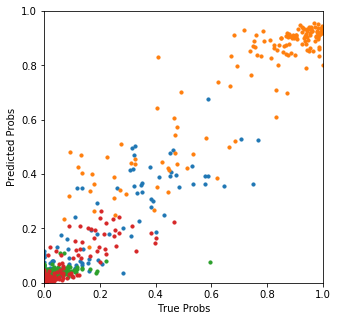

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1]);


# LR for trip generation

In [75]:
trpgen_train =  y[~train_test_index,-1]
trpgen_test =  y[train_test_index,-1]

In [85]:
print("PT")
trpgen_train = y[~train_test_index,3]
trpgen_test = y[train_test_index,3]

for a in [0,0.0000005, 0.000005, 0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 100, 500, 2000]:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print(a, lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 
          np.sum(lasso.coef_[:dim_demo] != 0), np.sum(lasso.coef_[dim_demo:] != 0))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

PT


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-02, tolerance: 1.373e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg,

0 0.9972954612957697 -1.6628053098061608 10 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


5e-07 0.6375094410115442 0.41449175108639946 10 259
5e-06 0.4971892121363253 0.43113560374101356 10 21
5e-05 0.3931230553860723 0.2973711026969096 9 1
0.0005 0.3660600976997851 0.2867726382865108 6 0
0.001 0.34984041117245623 0.27516550599128686 5 0
0.005 0.17920040751941502 0.14612443955138543 3 0
0.01 0.0 -4.235457568180223e-05 0 0
0.05 0.0 -4.235457568180223e-05 0 0
0.1 0.0 -4.235457568180223e-05 0 0
0.5 0.0 -4.235457568180223e-05 0 0
1 0.0 -4.235457568180223e-05 0 0
100 0.0 -4.235457568180223e-05 0 0
500 0.0 -4.235457568180223e-05 0 0
2000 0.0 -4.235457568180223e-05 0 0


In [86]:
print("Active")
trpgen_train = y[~train_test_index,0]
trpgen_test = y[train_test_index,0]

for a in [0,0.0000005, 0.000005, 0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 100, 500, 2000]:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print(a, lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 
          np.sum(lasso.coef_[:dim_demo] != 0), np.sum(lasso.coef_[dim_demo:] != 0))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

Active


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e-02, tolerance: 3.791e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg,

0 0.9978355421578006 -1.6454180156979277 10 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.540e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


5e-07 0.6972965433222733 0.5213568845679843 10 382
5e-06 0.5260623713155785 0.574841199608292 10 44
5e-05 0.3932802408658983 0.48407685900491215 10 3
0.0005 0.3433019815668499 0.468884249469257 6 0
0.001 0.331032155979759 0.45975387943932144 6 0
0.005 0.24952097014727548 0.3325464430090398 3 0
0.01 0.10429470958899456 0.13040276332753553 2 0
0.05 0.0 -0.00028335989418204477 0 0
0.1 0.0 -0.00028335989418204477 0 0
0.5 0.0 -0.00028335989418204477 0 0
1 0.0 -0.00028335989418204477 0 0
100 0.0 -0.00028335989418204477 0 0
500 0.0 -0.00028335989418204477 0 0
2000 0.0 -0.00028335989418204477 0 0


In [84]:
print("Auto")
trpgen_train = y[~train_test_index,1]
trpgen_test = y[train_test_index,1]

for a in [0,0.0000005, 0.000005, 0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 100, 500, 2000]:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print(a, lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 
          np.sum(lasso.coef_[:dim_demo] != 0), np.sum(lasso.coef_[dim_demo:] != 0))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

Auto


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.504e-02, tolerance: 7.704e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg,

0 0.9985711832925986 -0.7145943358131741 10 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.585e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


5e-07 0.7948178500966163 0.636347142709834 10 466
5e-06 0.6303113473622145 0.6809006832508182 10 55
5e-05 0.5162514081900162 0.5577859610403886 10 5
0.0005 0.43843774237681976 0.4979332756594257 8 0
0.001 0.431507505740116 0.4917538425499852 7 0
0.005 0.3792355934007072 0.4216677864017082 4 0
0.01 0.2647032844970676 0.2835869840075449 3 0
0.05 0.0 -0.0029195965307129423 0 0
0.1 0.0 -0.0029195965307129423 0 0
0.5 0.0 -0.0029195965307129423 0 0
1 0.0 -0.0029195965307129423 0 0
100 0.0 -0.0029195965307129423 0 0
500 0.0 -0.0029195965307129423 0 0
2000 0.0 -0.0029195965307129423 0 0


In [79]:
print("Auto")
trpgen_train = y[~train_test_index,1]
trpgen_test = y[train_test_index,1]

for a in [0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 100, 500, 2000]:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
    print(a, ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))
    
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.4f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', 
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))

Auto
5e-05 0.8394271918814298 0.6134187885567977
0.0005 0.7203235708660723 0.6686356391893977
0.001 0.6957110297012734 0.6753851104772668
0.005 0.649252933118616 0.6756729478131449
0.01 0.6303136629463459 0.6662270408068955
0.05 0.5729366752356145 0.6126413833510738
0.1 0.5427765893419965 0.5828262328671038
0.5 0.48439593422227445 0.5320256367192703
1 0.4678494862162712 0.5192032989980906
100 0.24942814333687102 0.27785176401091816
500 0.08934312402016809 0.09245061143143596
2000 0.026898267867253578 0.02489984225930586


In [80]:
print("PT")
trpgen_train =  y[~train_test_index,3]
trpgen_test =  y[train_test_index,3]
for a in [0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10, 15, 30, 50, 100, 200]:
# for a in [0.0005, 0.05, 0.5, 5, 50, 500]:
# for a in [0.0025]:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print(a, ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))

PT
5e-05 0.7958318586002884 0.3650975926453559
0.0005 0.6455559274356897 0.4232169097596532
0.001 0.6148614993535274 0.4305208288041439
0.005 0.5588898358586845 0.4386394609222679
0.01 0.53784509504421 0.4350228019619441
0.05 0.48562981847143305 0.3972418538530569
0.1 0.4620543495510572 0.37222884970744186
0.5 0.4172378644493897 0.3252251788667885
1 0.4029188611916814 0.3137148624069518
2 0.3908609470371761 0.30689298976780177
5 0.3759543477215298 0.3019136970761731
8 0.36637105676707504 0.2988761088144699
10 0.3606686123528774 0.29666880728941425
15 0.3475111526386111 0.2904144452950401
30 0.31397050625293255 0.2692761218185049
50 0.27917756042019415 0.24273187020634712
100 0.22128667960673365 0.1936142867907632
200 0.16028627983632537 0.139405190821011


In [81]:
print("Active")
trpgen_train =  y[~train_test_index,0]
trpgen_test =  y[train_test_index,0]
for a in [0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10, 15, 30, 50, 100, 200]:
# for a in [0.0005, 0.05, 0.5, 5, 50, 500]:
# for a in [0.0025]:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print(a, ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))

Active
5e-05 0.7966434505804108 0.488708237615997
0.0005 0.6510352514701796 0.5510123117658929
0.001 0.6209694983909433 0.5589125283878874
0.005 0.5617824055538488 0.5701775574563726
0.01 0.5374742468995406 0.5677881201317385
0.05 0.4741656417266784 0.5356068822175444
0.1 0.4445060695766505 0.5164259713747227
0.5 0.388873147613757 0.4868180758026378
1 0.3735650317108471 0.4800222657826373
2 0.3626628037415395 0.4747537379061113
5 0.35025302528545654 0.4655398729092779
8 0.3417895139865358 0.45648517589644877
10 0.33656483903972423 0.45025097362883615
15 0.3241535399522292 0.4344508846915829
30 0.2909818283674841 0.3895955576746565
50 0.255010770265246 0.3398798559721051
100 0.19363501792641102 0.2554617246322638
200 0.13004415360251875 0.16959553232752234


In [82]:
print("Trip Generation")
trpgen_train =  y[~train_test_index,-1]
trpgen_test =  y[train_test_index,-1]
for a in [0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 8, 10, 15, 30, 50, 100, 200]:
# for a in [0.0005, 0.05, 0.5, 5, 50, 500]:
# for a in [0.0025]:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print(a, ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))

Trip Generation
5e-05 0.6951037231021304 -0.15469529936069915
0.0005 0.47746396228610344 0.00646984567879727
0.001 0.433470835118016 0.03805991971541556
0.005 0.3512913178723125 0.10074800484948065
0.01 0.3232929062721781 0.12078328268271876
0.05 0.2793906436655088 0.14989140885280905
0.1 0.26804457375734314 0.15577739406883362
0.5 0.2500226105253317 0.16258998231418598
1 0.24333514136943324 0.16667550771038664
2 0.23421278654480915 0.17177001089974864
5 0.20975080123314138 0.17267086439637003
8 0.1888203553447313 0.16631928909167337
10 0.1770586999043634 0.16127837872082962
15 0.15382579158631893 0.14912987426866242
30 0.11384860335521207 0.12245738275201723
50 0.08824566635716946 0.10116436689588248
100 0.06100186166458621 0.0736371023710205
200 0.04124334939601326 0.04998449667281901


In [76]:
# dataloader and model definition

trainset2 = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(trpgen_train, dtype=torch.float))
trainloader2 = DataLoader(trainset2, batch_size=len(trainset2), shuffle=False)

testset2 = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(trpgen_test, dtype=torch.float))
testloader2 = DataLoader(testset2, batch_size=len(testset2), shuffle=False)

mseloss = nn.MSELoss(reduction='mean')

In [77]:
import linear_reg

In [39]:
demo_weights = torch.load(out_dir+"demo_weights.pt")

In [40]:
demo_weights['demo.weight']

tensor([[ 60.1201,   0.6450,   0.7284,   2.8149,  -1.1723,   3.2800,   0.6515,
          15.6323, -13.7578,   3.5966]])

In [48]:
model.demo.weight

Parameter containing:
tensor([[ 61.8849,   0.8933,   1.0213,   3.1698,  -1.3015,   2.9416,   1.2524,
          16.1536, -15.4054,   2.9638]], requires_grad=True)

In [42]:
image_weights = torch.load(out_dir+"image_weights.pt")

In [43]:
image_weights['embed.weight']

tensor([[ 0.0635, -0.0760, -0.0652,  ...,  0.0318,  0.1321, -0.0037]])

In [47]:
model.embed.weight

Parameter containing:
tensor([[-0.0001,  0.0041,  0.0016,  ..., -0.0003,  0.0084,  0.0007]],
       requires_grad=True)

In [60]:
# decay rates for embedding
w1_list = [1.3,1.4]
# decay rates for demo
w2_list = [0.007]
# lr_list = [0.005,0.01, 0.02]
lr1_list = [0.001,0.002,0.003]
lr2_list = [0.5,0.55]

dim_demo = len(demo_variables)
dim_embed = 2048*output_dim*output_dim

for lr1, lr2 in itertools.product(lr1_list, lr2_list):
    
    for w1, w2 in itertools.product(w1_list, w2_list):
    
        # model setup
        model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo, 
                              demo_weights=demo_weights, image_weights=image_weights)

        embed_params = []
        demo_params = []
        other_params = []
        for name, m in model.named_parameters():
    #             print(name)
            if 'embed' in name:
                embed_params.append(m)
            elif 'demo' in name:
                demo_params.append(m)
            else:
                other_params.append(m)

        optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1,'lr':lr1},
                                      {'params':demo_params,'weight_decay':w2,'lr':lr2},
                                      {'params':other_params,'weight_decay':0}])

        # model training
        ref1 = 0
        ref2 = 0

        for epoch in range(500):

            mse_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader2):
                # Compute prediction and loss
                pred = model(x_batch[:, dim_demo:], x_batch[:, :dim_demo])
                pred = F.relu(pred).squeeze()

                mse = mseloss(pred, y_batch)
                mse_ += mse.item()

                # Backpropagation
                optimizer.zero_grad()
                mse.backward()
                optimizer.step()


            train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
            train_rmse = np.sqrt(mse_/len(trainset2))

            if epoch % 10 == 0:
                print(f"[epoch: {epoch:>2d}] Train RMSE : {train_rmse:.3f} R2 score: {train_r:.3f} ")
            loss_ = train_rmse

            if epoch % 5 == 0:
                if epoch > 50:
                    if (np.abs(loss_ - ref1)/ref1<ref1*0.001) & (np.abs(loss_ - ref2)/ref2<ref2*0.001):
                        print("Early stopping at epoch", epoch)
                        break
                    if (ref1 < loss_) & (ref1 < ref2):
                        print("Diverging. stop.")
                        break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                else:
                    best = loss_
                    best_epoch = epoch

                ref2 = ref1
                ref1 = loss_

            if epoch % 10 == 0:

                mse_ = 0 

                for batch, (x_batch, y_batch) in enumerate(testloader2):
                    pred = model(x_batch[:, dim_demo:], x_batch[:, :dim_demo])
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()

                test_rmse = np.sqrt(mse_/len(testset2))
                test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                print(f"[epoch: {epoch:>2d}] Test RMSE {test_rmse:.3f} R2 score: {test_r:.3f} ")


        with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
            f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
                (model_run_date, model_type, zoomlevel, "LR", lr1, lr2, w1,w2, 
                  train_rmse, train_r, test_rmse, test_r))

[epoch:  0] Train RMSE : 0.358 R2 score: 0.293 
[epoch:  0] Test RMSE 1.009 R2 score: 0.158 
[epoch: 10] Train RMSE : 0.360 R2 score: 0.285 
[epoch: 10] Test RMSE 0.973 R2 score: 0.216 
[epoch: 20] Train RMSE : 0.359 R2 score: 0.289 
[epoch: 20] Test RMSE 0.973 R2 score: 0.216 
[epoch: 30] Train RMSE : 0.359 R2 score: 0.290 
[epoch: 30] Test RMSE 0.971 R2 score: 0.220 
[epoch: 40] Train RMSE : 0.359 R2 score: 0.290 
[epoch: 40] Test RMSE 0.969 R2 score: 0.222 
[epoch: 50] Train RMSE : 0.359 R2 score: 0.290 
[epoch: 50] Test RMSE 0.969 R2 score: 0.223 
Early stopping at epoch 55
[epoch:  0] Train RMSE : 0.359 R2 score: 0.290 
[epoch:  0] Test RMSE 1.010 R2 score: 0.155 
[epoch: 10] Train RMSE : 0.361 R2 score: 0.280 
[epoch: 10] Test RMSE 0.974 R2 score: 0.214 
[epoch: 20] Train RMSE : 0.360 R2 score: 0.286 
[epoch: 20] Test RMSE 0.974 R2 score: 0.214 
[epoch: 30] Train RMSE : 0.359 R2 score: 0.289 
[epoch: 30] Test RMSE 0.971 R2 score: 0.219 
[epoch: 40] Train RMSE : 0.359 R2 score: 0.

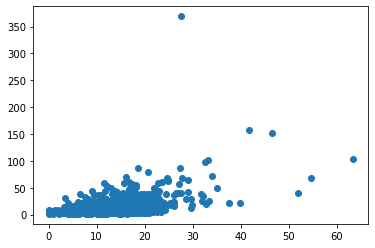

In [46]:
plt.scatter(pred.detach(), y_batch.detach())